# Proyecto III:  Gans

La idea de este ptoyecto es que implementen una GAN (Generative Adversarial Netwrok), para realizar la generación de imagenes tipo MNIST de Fashion y del dataset de imagenes de cartoon, los mismos dataset que utilizarón en el taller de variational autoencoders. Para este ejercicio, se pueden guiar del blog que pueden encontrar en este [link](https://blog.paperspace.com/implementing-gans-in-tensorflow/), el cual es el mismo que esta publicado en la página del curso.

La idea es que comparen los resultados obtenidos en el taller con el variational autoencoder, con los resultados obtenidos con las gans. Para esto Por favor realizar los siguientes modelos:

1. Realicen un modelo GAN, utilizando como decoder una arquitectura similar a la utilizada en el decoder del variational autoencoder, pero inicializando los pesos desde cero.
2. Realicen un modelo GAN, utilizando la capa decoder ya entrenada que obtuvieron en el variational autoencoder.
3. Realicen un modelo GAN con una arquitectura diferente a la utilizada en el variational autoencoder. En esta arquitectura la idea es que, basado en los resultados obtenidos, ustedes propongan cambios. Cada cambio debe estar justificado.
4. Describa como fue el entrenamiento para todos los modelos. ¿Qué modelo se entreno más rápido?, ¿con cual tuvierón más problemas?, etc...
5. Compare la generación obtenida con los modelos GAN y el variational autoencoder. ¿Qué pueden concluir?
6. Describa los pro y contras, desde su punto de vista, de realizar modelos utilizando autoencoders variacionales, y GANS.

Cada parte del proyecto, cada segmento de código debe estar completamnete justificado y los resultados deben presentar un análisis profundo. Cada información que coloquen en el taller debe estar justificada con imagenes de resultados, graficas de entrenamiento, y demas información que consideren necesaria.

La entrega del proyecto es para el **Viernes 3 de Junio a las 11:59 p.m.**

# Desarrollo

En primer lugar, importamos todas las librerías necesarias.

In [1]:
import tensorflow as tf
#from tensorflow import keras
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

from keras import preprocessing
from keras.models import Sequential
from keras.layers import Conv2D,Dropout,Dense,Flatten,Conv2DTranspose,BatchNormalization,LeakyReLU,Reshape, MaxPool2D,ZeroPadding2D
from keras import layers, losses
from keras.datasets import fashion_mnist
from keras.models import Model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

A continuación, definimos ciertas funciones auxiliares.

La primera de ellas, `plt_reconstruction` se encarga de graficar las imágenes que fueron reconstruidas, como input tiene el número de imágenes que se quieren graficar y los datos de las imágenes.

In [2]:
def plt_reconstruction(n, decoded_imgs):
    plt.figure(figsize=(20,4))
    for i in range(n):
        # display reconstruction
        bx = plt.subplot(1, n, i + 1)
        plt.title("reconstructed")
        plt.imshow(tf.squeeze(decoded_imgs[i]))
        plt.gray()
        bx.get_xaxis().set_visible(False)
        bx.get_yaxis().set_visible(False)
    plt.show()

In [3]:
def plt_original_reconstruction(n, x_test, decoded_imgs):
    plt.figure(figsize=(20, 4))
    for i in range(n):

        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.title("original")
        plt.imshow(tf.squeeze(x_test[i]))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        bx = plt.subplot(2, n, i + n + 1)
        plt.title("reconstructed")
        plt.imshow(tf.squeeze(decoded_imgs[i]))
        plt.gray()
        bx.get_xaxis().set_visible(False)
        bx.get_yaxis().set_visible(False)
    plt.show()

# Modelos GAN
Ahora, dado que a lo largo de este notebook se implementaran diferentes redes generativas antagónicas, se implementó una clase general, la cual permite definir diferentes tipos de arquitecturas para el generador y el descriptor. Adicional a ello, nos permite definir las funciones de costo y la forma de entrenamiento del modelo.

In [4]:
class GAN(Model):
    def __init__(self, discriminator, generator, latent_dim):
        # super(GAN, self).__init__()
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss = tf.keras.metrics.Mean(name="D")
        self.g_loss = tf.keras.metrics.Mean(name="G")
    
    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
    
    @property
    def metrics(self):
        return [self.d_loss, self.g_loss]
    
    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Step 1. Train the discriminator with both real images (label as 1) and fake images (classified as label as 0)
        with tf.GradientTape() as tape:
            # Compute discriminator loss on real images
            pred_real = self.discriminator(real_images, training=True)
            d_loss_real = self.loss_fn(tf.ones((batch_size, 1)), pred_real)

            # Compute discriminator loss on fake images
            fake_images = self.generator(noise)
            pred_fake = self.discriminator(fake_images, training=True)
            d_loss_fake = self.loss_fn(tf.zeros((batch_size, 1)), pred_fake)

            # total discriminator loss
            d_loss = (d_loss_real + d_loss_fake)/2
        grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_variables))


        # Step 2. Train the generator (do not update weights of the discriminator)
        # G wants D to think the fake images are real (label as 1)
        misleading_labels = tf.ones((batch_size, 1))

        with tf.GradientTape() as tape:
            fake_images = self.generator(noise, training=True)
            pred_fake = self.discriminator(fake_images, training=True)
            g_loss = self.loss_fn(misleading_labels, pred_fake)
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        self.d_loss.update_state(d_loss)
        self.g_loss.update_state(g_loss)

        return {
            "d_loss": self.d_loss.result(),
            "g_loss": self.g_loss.result(),
        }

# Fashion MNIST

Cargamos los datos y los normalizamos. Es importante notar que estos en un inicio se encuentran en un rango de [0, 255] y posteriormente se pasan al rango [-1, 1]. Esto para facilitar el procesamiento de los mismos.

In [5]:
(x_train, _), (_, _) = fashion_mnist.load_data()
X_train = x_train[..., tf.newaxis].astype('float32') / 255.
X_train = X_train*2 - 1.

4431872/4422102 [==============================] - 0s 0us/step


## Primer modelo - Fashion MNIST

### Generator
Para este modelo, se tomó una arquitectura previamente definida para el generador. Esta arquitectura está basada en la implementada para el decodificador de un autoencoder variacional. Podemos observar que está compuesta por tres capas de la transpuesta de una capa de convolución. Es relevante notar también que, la última capa utiliza como función de activación la función `tanh`, dado que, junto con el uso de funciones de activación acotadas, permite que la red aprenda con mayor velocidad cubriendo el espacio de color.

In [6]:
latent_dim = 100
decoder_model_0 = Sequential(
    [Dense(7 * 7 * 64, input_dim=latent_dim, activation="relu"),
     Reshape((7, 7, 64)),
     Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same"),
     Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same"),
     Conv2DTranspose(1, 3, activation="tanh", padding="same")],
    name = "Generator"
)

In [7]:
decoder_model_0.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3136)              316736    
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        289       
 ranspose)                                                       
                                                         

### Discriminator

Definimos el discriminador haciendo uso de capas convoluciones e implementando capas con la función de activación LEakyReLU, esto siguiendo las pautas establecidas para las `Deep Convolutional GANs` en el paper *unsupervised representation learning with deep convolutional generative adversarial networks*

In [8]:
discriminator_0 = Sequential(
    [Conv2D(64, (5, 5), strides=(2, 2), padding="same", input_shape=(28,28,1)),
     BatchNormalization(),
     LeakyReLU(alpha=0.2),
     Conv2D(128, (5, 5), strides=(2, 2), padding="same"),
     BatchNormalization(),
     LeakyReLU(alpha=0.2),
     Flatten(),
     Dropout(0.3),
     Dense(1, activation="sigmoid")],
    name = "Discriminator"
)

In [9]:
discriminator_0.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 64)       256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)       

Una vez se ha definido el generador y el discriminador, procedemos a instanciar el modelo y compilarlo.

In [10]:
gan_0 = GAN(discriminator=discriminator_0,
            generator=decoder_model_0, 
            latent_dim=latent_dim)

In [11]:
lr = 0.002
gan_0.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=lr, beta_1 = 0.5),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=lr, beta_1 = 0.5),
    loss_fn=tf.keras.losses.BinaryCrossentropy(),
)

Ahora, procedemos a entrenar el modelo.

In [12]:
gan_0.fit(X_train, epochs=50)

Epoch 1/50
1875/1875 [==============================] - 29s 8ms/step - d_loss: 0.5482 - g_loss: 2.8334
Epoch 2/50
1875/1875 [==============================] - 16s 8ms/step - d_loss: 0.5672 - g_loss: 1.6779
Epoch 3/50
1875/1875 [==============================] - 16s 8ms/step - d_loss: 0.5633 - g_loss: 1.5808
Epoch 4/50
1875/1875 [==============================] - 16s 8ms/step - d_loss: 0.5580 - g_loss: 1.5705
Epoch 5/50
1875/1875 [==============================] - 16s 8ms/step - d_loss: 0.5570 - g_loss: 1.5717
Epoch 6/50
1875/1875 [==============================] - 16s 9ms/step - d_loss: 0.5411 - g_loss: 1.6205
Epoch 7/50
1875/1875 [==============================] - 15s 8ms/step - d_loss: 0.5335 - g_loss: 1.6529
Epoch 8/50
1875/1875 [==============================] - 15s 8ms/step - d_loss: 0.5266 - g_loss: 1.6775
Epoch 9/50
1875/1875 [==============================] - 21s 11ms/step - d_loss: 0.5142 - g_loss: 1.7160
Epoch 10/50
1875/1875 [==============================] - 26s 14ms/step -

Para visualizar el funcionamiento del modelo, se genera ruido a partir de una distribución normal y esta es dad como entrada al generador. Este genera un conjunto de imágenes de a cuerdo a la dimensión del ruido generado. Dependiendo del ruido, se generan imágenes similares a las originales.  

In [13]:
noise = np.random.normal(size=[5,latent_dim])
gen_image = decoder_model_0.predict(noise)

Text(0.5, 1.0, 'Noise')

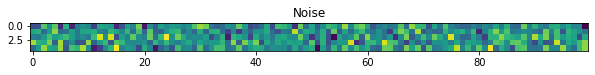

In [14]:
plt.figure(figsize=(10,4))
plt.imshow(noise)
plt.title("Noise")

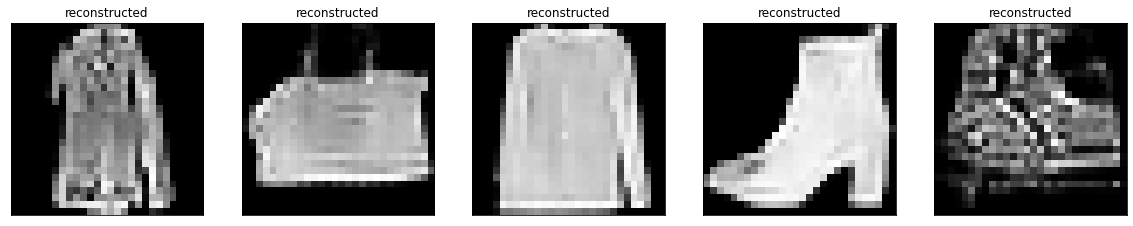

In [15]:
plt_reconstruction(5, gen_image)

Para poder analizar de objetivamente el rendimiento del modelo, es importante recordar que, dada la función de costo de los modelos GANs, el generador trata de minimizar la función de costo, mientras que el discriminador trata de maximizarla. Ahora bien, como podemos observar en el entrenamiento de este modelo, los valores que se obtienen en el costo para el generador y el discriminador, no varían a lo largo del entrenamiento. Esto puede deberse a un estancamiento generado por diferentes factores, tales como la no normalización en cada capa de la red o el tamaño de la misma. Este comportamiento se ve reflejado en las imágenes reconstruidas a partir del ruido generado, ya que, como se puede notar, solo se aprecia de manera clara la generación de una bota en la cuarta imagen.

## Segundo modelo - Fashion MNIST

Para el segundo modelo, se hará uso del decodificador entrenado de un modelo VAE previamente implementado. Por lo cual, en primer lugar, definimos el modelo VAE. Es importante resaltar que, el decoder implementa la misma arquitectura planteada anteriormente para el generador, con la diferencia que en la última capa se cuenta con una función de activación `sigmoid`.

Es relevante resaltar que, dado esto, el rango de los datos está en [0,1] dado que la función de activación se encuentra definida en este rango.

### Varational Autoencoder

In [16]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


class VAE(Model):
    def __init__(self, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = self._encoder(100)#latent_dim
        self.decoder = self._decoder(100)#latent_dim
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")
        
    def _encoder(self, latent_dim):
        encoder_inputs = tf.keras.Input(shape=(28, 28, 1))
        x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
        x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.Flatten()(x)
        x = layers.Dense(16, activation="relu")(x)
        z_mean = layers.Dense(latent_dim, name="z_mean")(x)
        z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
        z = Sampling()([z_mean, z_log_var])
        encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
        #encoder.summary()
        return encoder

    def _decoder(self, latent_dim):
        latent_inputs = tf.keras.Input(shape=(latent_dim,))
        x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
        x = layers.Reshape((7, 7, 64))(x)
        x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
        decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
        decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
        #decoder.summary()
        return decoder
    
    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

Una vez definido el modelo VAE, procedemos a cargar otra vez los datos para el entrenamiento del mismo.

In [17]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()
X_train = x_train[..., tf.newaxis].astype('float32') / 255.
X_test = x_test[..., tf.newaxis].astype('float32') / 255.

#X_train = X_train*2 - 1.

Compilamos y entrenamos el modelo.

In [18]:
vae = VAE()
vae.compile(optimizer=tf.keras.optimizers.Adam())

In [19]:
vae.fit(X_train, epochs=30, batch_size=128)

Epoch 1/30
469/469 [==============================] - 6s 9ms/step - loss: 401.7421 - reconstruction_loss: 358.1335 - kl_loss: 5.6685
Epoch 2/30
469/469 [==============================] - 4s 9ms/step - loss: 328.7806 - reconstruction_loss: 317.7915 - kl_loss: 9.1065
Epoch 3/30
469/469 [==============================] - 4s 9ms/step - loss: 323.0047 - reconstruction_loss: 312.3647 - kl_loss: 9.5648
Epoch 4/30
469/469 [==============================] - 4s 9ms/step - loss: 317.7013 - reconstruction_loss: 307.2290 - kl_loss: 9.1352
Epoch 5/30
469/469 [==============================] - 4s 9ms/step - loss: 313.2028 - reconstruction_loss: 303.0695 - kl_loss: 8.5509
Epoch 6/30
469/469 [==============================] - 4s 9ms/step - loss: 309.2399 - reconstruction_loss: 300.8712 - kl_loss: 7.9586
Epoch 7/30
469/469 [==============================] - 4s 9ms/step - loss: 306.5933 - reconstruction_loss: 299.1855 - kl_loss: 7.2886
Epoch 8/30
469/469 [==============================] - 4s 9ms/step - l

Verificamos el correcto funcionamiento del mismo. Podemos observar que las imágenes reconstruidas son semejantes a la imagen original.

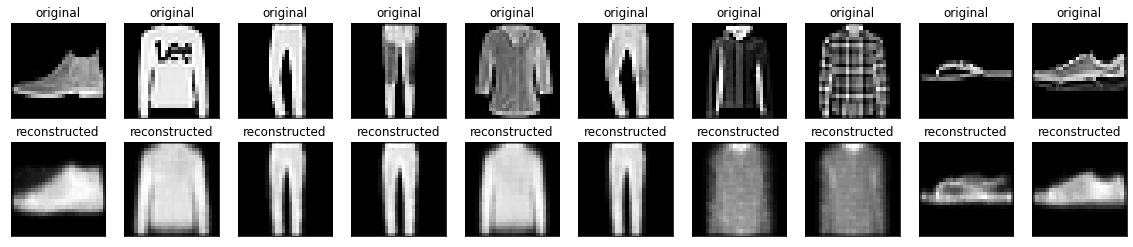

In [20]:
z_mean, z_logvar, samp = vae.encoder.predict(X_test)
decoded_samp = vae.decoder.predict(samp)
plt_original_reconstruction(10, X_test, decoded_samp)

Ahora bien, definimos el generador como el decodificador del modelo VAE una vez se ha entrenado.

In [21]:
decoder_model_1 = vae.decoder
decoder_model_1.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_3 (Dense)             (None, 3136)              316736    
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 14, 14, 64)       36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 28, 28, 1)        289 

Para poder tener un mejor punto de comparación, se implementó el mismo discriminador que el del modelo pasado. 

In [22]:
discriminator_1 = Sequential(
    [Conv2D(64, (5, 5), strides=(2, 2), padding="same", input_shape=(28,28,1)),
     BatchNormalization(),
     LeakyReLU(alpha=0.2),
     Conv2D(128, (5, 5), strides=(2, 2), padding="same"),
     BatchNormalization(),
     LeakyReLU(alpha=0.2),
     Flatten(),
     Dropout(0.3),
     Dense(1, activation="sigmoid")],
    name = "Discriminator"
)
discriminator_1.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 batch_normalization_2 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 batch_normalization_3 (Batc  (None, 7, 7, 128)        512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 7, 7, 128)       

Procedemos a instanciar el modelo, compilarlo y entrenarlo.

In [23]:
latent_dim = 100
gan_1 = GAN(discriminator=discriminator_1,
            generator=decoder_model_1, 
            latent_dim=latent_dim)

In [24]:
lr = 0.002
gan_1.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=lr, beta_1 = 0.5),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=lr, beta_1 = 0.5),
    loss_fn=tf.keras.losses.BinaryCrossentropy(),
)

In [25]:
gan_1.fit(X_train, epochs=50)

Epoch 1/50
1875/1875 [==============================] - 17s 8ms/step - d_loss: 0.5729 - g_loss: 2.5860
Epoch 2/50
1875/1875 [==============================] - 15s 8ms/step - d_loss: 0.4674 - g_loss: 2.1461
Epoch 3/50
1875/1875 [==============================] - 15s 8ms/step - d_loss: 0.4782 - g_loss: 2.0742
Epoch 4/50
1875/1875 [==============================] - 15s 8ms/step - d_loss: 0.4867 - g_loss: 2.0179
Epoch 5/50
1875/1875 [==============================] - 16s 8ms/step - d_loss: 0.4744 - g_loss: 2.0775
Epoch 6/50
1875/1875 [==============================] - 15s 8ms/step - d_loss: 0.4723 - g_loss: 2.1091
Epoch 7/50
1875/1875 [==============================] - 15s 8ms/step - d_loss: 0.4605 - g_loss: 2.1506
Epoch 8/50
1875/1875 [==============================] - 16s 9ms/step - d_loss: 0.4588 - g_loss: 2.1765
Epoch 9/50
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.4565 - g_loss: 2.1716
Epoch 10/50
1875/1875 [==============================] - 15s 8ms/step - d

In [26]:
noise = np.random.normal(size=[5,latent_dim])
gen_image = decoder_model_1.predict(noise)

Text(0.5, 1.0, 'Noise')

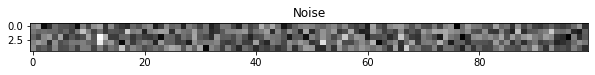

In [27]:
plt.figure(figsize=(10,4))
plt.imshow(noise)
plt.title("Noise")

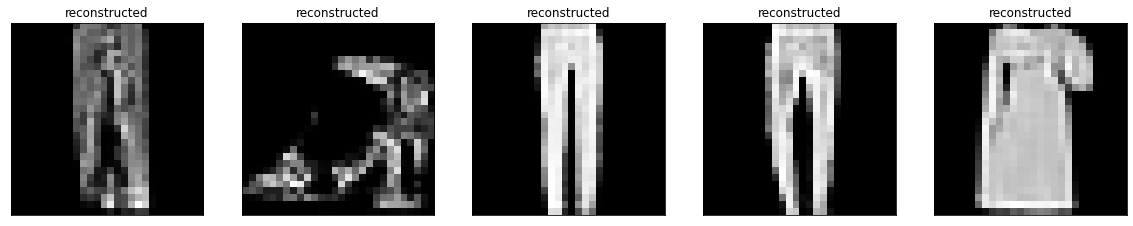

In [28]:
plt_reconstruction(5, gen_image)

Este segundo modelo, tiene un comportamiento muy similar al anterior, pues, la función de costo no tiene mayor variación para ambos modelos (generador y discriminador). De igual forma, se ve un resultado poco satisfactorio en las imágenes, pues, aunque en este caso se puedan apreciar satisfactoriamente 3 de las 5 imágenes (pantalones), esto se puede deber al ruido con el cual fueron generadas las imágenes.

## Tercer modelo - Fashion MNIST

El tercer modelo creado busca mejorar los dos modelos anteriores. Para ello, se tienen en cuenta los resultados vistos anteriormente y las diferentes pautas especificadas en el paper *UNSUPERVISED REPRESENTATION LEARNING
WITH DEEP CONVOLUTIONAL GENERATIVE ADVERSARIAL NETWORKS*.

En primer lugar, se vuelven a cargar los datos, con el fin de cambiar nuevamente su rango y definir este entre [-1,1].

In [29]:
(x_train, _), (_, _) = fashion_mnist.load_data()
X_train = x_train[..., tf.newaxis].astype('float32') / 255.
X_train = X_train*2 - 1.

Para el generador, podemos observar que este consta de una capa densa y dos capas convolucionales transpuestas, donde la primera tienen como función de activación la función `relu` y la última `tanh`. También, luego de la capa densa y luego de la primera capa convolucional, se adicionó una capa de normalización para mejorar el entrenamiento en la capa posterior.

Adicionalmente, se incrementó el número de neuronas por capa, pero también el tamaño del kernel, de esta forma, se quiere mapear los datos sin tener tanto detalle sobre cada región de la imagen, buscando tener una mejor extracción o identificación de características.

In [59]:
latent_dim = 100
w_init = tf.keras.initializers.HeNormal(seed=42)
decoder_model_2 = Sequential(
    [Dense(7 * 7 * 128, input_shape=[latent_dim], kernel_initializer=w_init),
     Reshape([7, 7, 128]),
     BatchNormalization(),
     Conv2DTranspose(64, kernel_size=5, strides=2, padding="same",
                                 activation="relu"),
     BatchNormalization(),
     Conv2DTranspose(1, kernel_size=5, strides=2, padding="same",
                                 activation="tanh")],
    name = "Generator"
)
decoder_model_2.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 6272)              633472    
                                                                 
 reshape_10 (Reshape)        (None, 7, 7, 128)         0         
                                                                 
 batch_normalization_23 (Bat  (None, 7, 7, 128)        512       
 chNormalization)                                                
                                                                 
 conv2d_transpose_23 (Conv2D  (None, 14, 14, 64)       204864    
 Transpose)                                                      
                                                                 
 batch_normalization_24 (Bat  (None, 14, 14, 64)       256       
 chNormalization)                                                
                                                         

Para la creación del discriminador, es impórtente resaltar que para la función de activación `LeakyRelu` se utilizó un slope de 0.2, valor que mostró buenos resultados, los cuales se registran en el paper. Adicionalmente, se añadió una capa de Dropout con un valor de 0.5, esto con el fin de dar mayor libertad al modelo.

In [60]:
discriminator_2 = Sequential(
    [Conv2D(64, (5, 5), strides=(2, 2), padding="same", 
            input_shape=(28,28,1), activation=LeakyReLU(alpha=0.2)),
     BatchNormalization(),
     Dropout(0.5),
     Conv2D(128, (5, 5), strides=(2, 2), padding="same",
            activation=LeakyReLU(alpha=0.2)),
     Flatten(),
     Dropout(0.3),
     Dense(1, activation="sigmoid")],
    name = "Discriminator"
)
discriminator_2.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 14, 14, 64)        1664      
                                                                 
 batch_normalization_25 (Bat  (None, 14, 14, 64)       256       
 chNormalization)                                                
                                                                 
 dropout_5 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 7, 7, 128)         204928    
                                                                 
 flatten_6 (Flatten)         (None, 6272)              0         
                                                                 
 dropout_6 (Dropout)         (None, 6272)              0         
                                                     

In [61]:
gan_2 = GAN(discriminator=discriminator_2,
            generator=decoder_model_2, 
            latent_dim=latent_dim)

Como otra modificación que se tiene en cuenta para la implementación de este modelo, es el `learning_rate`, pues en el paper, se sugiere utilizar 0.001 y en caso de ser muy grande, se sugiere 0.0002. Como pudimos observar en los anteriores modelos, en ellos se utilizó un `learning_rate` de 0.0002, por cuestiones experimentales, para este modelo, se usó 0.001. Adicionalmente, en el paper se registraron resultados estables haciendo uso de un valor de beta de 0.5, pues de ser mayor, los modelos mostraban comportamientos inestables y oscilatorios 

In [62]:
lr = 0.001
gan_2.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=lr, beta_1 = 0.5),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=lr, beta_1 = 0.5),
    loss_fn=tf.keras.losses.BinaryCrossentropy(),
)

In [63]:
gan_2.fit(X_train, epochs=50)

Epoch 1/50
1875/1875 [==============================] - 18s 9ms/step - d_loss: 0.3933 - g_loss: 2.1833
Epoch 2/50
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.5799 - g_loss: 1.8821
Epoch 3/50
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6008 - g_loss: 1.6304
Epoch 4/50
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.5993 - g_loss: 1.4402
Epoch 5/50
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.5893 - g_loss: 1.3691
Epoch 6/50
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.5763 - g_loss: 1.3104
Epoch 7/50
1875/1875 [==============================] - 18s 9ms/step - d_loss: 0.5744 - g_loss: 1.2911
Epoch 8/50
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.5704 - g_loss: 1.2815
Epoch 9/50
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.5614 - g_loss: 1.3143
Epoch 10/50
1875/1875 [==============================] - 17s 9ms/step - d

Text(0.5, 1.0, 'Noise')

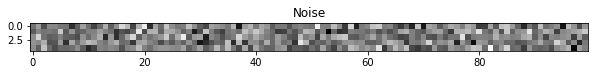

In [131]:
noise = np.random.normal(size=[5,latent_dim])
gen_image = decoder_model_2.predict(noise)
plt.figure(figsize=(10,4))
plt.imshow(noise)
plt.title("Noise")

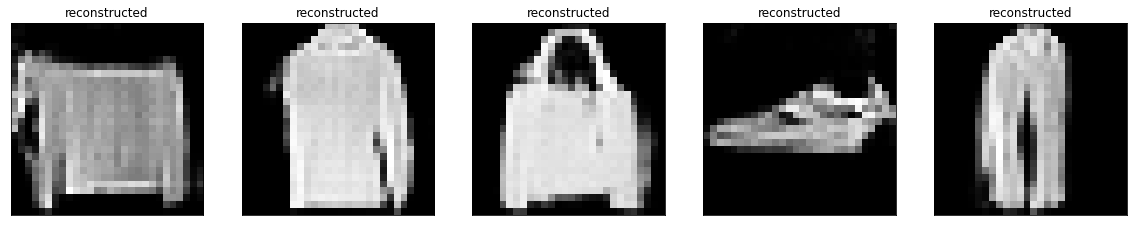

In [132]:
plt_reconstruction(5, gen_image)

Podemos observar que para este caso, el modelo tiene un mejor comportamiento, pues el gap entre el error del generador y el discriminador es pequeño. Adicionalmente, como podemos observar en las imágenes, se tiene una mejor salida, pues cada una de ellas puede ser asociada fácilmente a un objeto (bolso, zapatos, camisa, pantalones). También, podemos observar que se ha aumentado la variación entre este dado el ruido, es decir, el modelo es capaz de crear imágenes sin tanta repetición.  

# Cartoon Dataset
Ahora, se repetirá el proceso anterior, solamente que para este caso, se tiene en cuenta los datos del Cartoon Dataset.

En primer lugar, se cargan los datos. Dado el tamaño de estos y para facilitar su almacenamiento, estos fueron guardados en Google Drive. Para cargarlos, se hizo uso de la funcion image_dataset_from_directory, la cual genera un dataset de tensorflow con las imágenes contenidas en la carpeta. Otra nota importante es que, para por cuestiones de almacenamiento, se emplearon solamente de 10.000 imágenes.

In [6]:
#from google.colab import drive

# drive.mount('/content/drive')
# train_data = tf.keras.preprocessing.image_dataset_from_directory(
#     '/content/drive/MyDrive/cartoonset10k',
#     label_mode=None)

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    'cartoonset10k',
    label_mode=None)

Found 10000 files belonging to 1 classes.


Para verificar que los datos se hayan cargado exitosamente, visualizamos algunos de ellos.

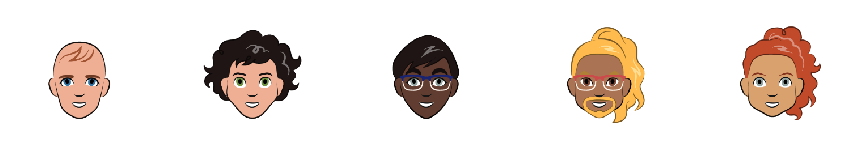

In [7]:
plt.figure(figsize=(15, 15))
for images in train_data.take(1):
    for i in range(5):
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

Como se realizó al comienzo del notebook, realizamos otra vez la implementación de la clase que nos permitirá definir de manera más fácil el modelo GAN con un discriminador y generador, específicos. Esta implementación se hizo nuevamente debido a unos cambios efectuados en el paso de entrenamiento para el correcto funcionamiento con base en los datos.

In [8]:
class GAN(Model):
    def __init__(self, discriminator, generator, latent_dim):
        # super(GAN, self).__init__()
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss = tf.keras.metrics.Mean(name="D")
        self.g_loss = tf.keras.metrics.Mean(name="G")
    
    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
    
    @property
    def metrics(self):
        return [self.d_loss, self.g_loss]
    
    @tf.function
    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Step 1. Train the discriminator with both real images (label as 1) and fake images (classified as label as 0)
        with tf.GradientTape() as tape:
            # Compute discriminator loss on real images
            pred_real = self.discriminator(real_images, training=True)
            d_loss_real = self.loss_fn(tf.ones((batch_size, 1)), pred_real)

            # Compute discriminator loss on fake images
            fake_images = self.generator(noise)
            pred_fake = self.discriminator(fake_images, training=True)
            d_loss_fake = self.loss_fn(tf.zeros((batch_size, 1)), pred_fake)

            # total discriminator loss
            d_loss = (d_loss_real + d_loss_fake)/2
        grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_variables))


        # Step 2. Train the generator (do not update weights of the discriminator)
        # G wants D to think the fake images are real (label as 1)
        misleading_labels = tf.ones((batch_size, 1))

        with tf.GradientTape() as tape:
            fake_images = self.generator(noise, training=True)
            pred_fake = self.discriminator(fake_images, training=True)
            g_loss = self.loss_fn(misleading_labels, pred_fake)
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        self.d_loss.update_state(d_loss)
        self.g_loss.update_state(g_loss)

        return {
            "d_loss": self.d_loss.result(),
            "g_loss": self.g_loss.result(),
        }

## Primer modelo - Cartoon dataset

Procedemos a implementar el primer modelo. 

In [9]:
normalization_layer = layers.Rescaling(scale=1./127.5, offset=-1)
normalized_data = train_data.map(lambda x: normalization_layer(x))

### Generador

Nuevamente, se hará uso de una arquitectura previamente definida para un Varational autoencoder como generador.


In [10]:
latent_dim = 100
generate_model_0 = Sequential(
    [Dense(32*32*64, input_dim=latent_dim, name='dense_1', activation="relu"),
     Reshape((32,32,64), name='Reshape'),
     Conv2DTranspose(64, 3, strides=2, padding='same',name='conv_transpose_1'),
     BatchNormalization(),
     LeakyReLU(0.2, name='lrelu_1'),
     Conv2DTranspose(32, 3, strides=2, padding='same', name='conv_transpose_2'),
     BatchNormalization(),
     LeakyReLU(0.2, name='lrelu_2'),
     Conv2DTranspose(3, 3, strides=2, padding='same', activation='tanh', name='conv_transpose_3')],
     name="Generator"
)
generate_model_0.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 65536)             6619136   
_________________________________________________________________
Reshape (Reshape)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv_transpose_1 (Conv2DTran (None, 64, 64, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 64)        256       
_________________________________________________________________
lrelu_1 (LeakyReLU)          (None, 64, 64, 64)        0         
_________________________________________________________________
conv_transpose_2 (Conv2DTran (None, 128, 128, 32)      18464     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      12

Definimos un discriminador, esta vez, desde el comienzo se tiene en cuenta las pautas establecidas en el paper, razón por la cual, luego de cada capa convolucional, se hace uso de una capa con función de activación `LeakyReLU` y junto a ello, se implementa una capa de Dropout. Debido al tamaño de los datos y a la cantidad de los mismos, se implementa un modelo más profundo, es decir, con una mayor cantidad de capas convolucionales.

In [11]:
discriminator_3 = Sequential(
    [Conv2D(32, kernel_size=3, strides=2, input_shape=(256,256,3), padding="same"),
     LeakyReLU(alpha=0.2),
     Dropout(0.2),
     Conv2D(64, kernel_size=3, strides=2, padding="same"),
     BatchNormalization(momentum=0.7),
     LeakyReLU(alpha=0.3),
     Dropout(0.2),
     Conv2D(128, kernel_size=3, strides=2, padding="same"),
     BatchNormalization(momentum=0.8),
     LeakyReLU(alpha=0.2),
     Dropout(0.2),
     Conv2D(256, kernel_size=3, strides=1, padding="same"),
     BatchNormalization(momentum=0.7),
     LeakyReLU(alpha=0.3),
     Dropout(0.2),
     Conv2D(512, kernel_size=3, strides=1, padding="same"),
     BatchNormalization(momentum=0.8),
     LeakyReLU(alpha=0.2),
     Dropout(0.2),
     Flatten(),
     Dense(1, activation='sigmoid')]
)
discriminator_3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 64)        0

Creamos el modelo, lo compilamos y efectuamos el entrenamiento.

In [15]:
gan_3 = GAN(discriminator=discriminator_3,
            generator=generate_model_0, 
            latent_dim=latent_dim)

In [16]:
lr = 0.002
gan_3.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=lr, beta_1 = 0.5),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=lr, beta_1 = 0.5),
    loss_fn=tf.keras.losses.BinaryCrossentropy(),
)

In [ ]:
gan_3.fit(normalized_data, epochs=20)

Epoch 1/20
313/313 [==============================] - 1658s 5s/step - d_loss: 15.1893 - g_loss: 49.1604
Epoch 2/20
  6/313 [..............................] - ETA: 29:34 - d_loss: 32.5012 - g_loss: 50.7174

Una vez más, para visualizar el funcionamiento del modelo, generamos ruido a partir de una distribución normal que se toma como entrada al generador.

In [ ]:
noise = np.random.normal(size=[5,latent_dim])
gen_image = decoder_model_0.predict(noise)
plt.figure(figsize=(10,4))
plt.imshow(noise)
plt.title("Noise")

In [ ]:
plt_reconstruction(5, gen_image)

## Segundo modelo - Cartoon dataset

Para el segundo modelo, al igual que en el caso de fashion mnist, se hizo uso del decoder ya entrenado, para ello, se definió el modelo VAE, se entrenó y posteriormente se usó en la implementación de la GAN. Aquí, es importante resaltar que, dado que no se utiliza en la última capa la función de activación `tanh`, los datos se encuentran en el rango [0,1].

In [168]:
normalization_layer = layers.Rescaling(scale= 1./255)
normalized_data = train_data.map(lambda x: normalization_layer(x))
# Try to pass to a numpy array

In [154]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class VAE(Model):
    def __init__(self, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = self._encoder(100)#latent_dim
        self.decoder = self._decoder(100)#latent_dim
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")
        
    def _encoder(self, latent_dim):
        inputs = tf.keras.Input(shape=(256, 256, 3), name='input_layer')
        x = layers.Conv2D(32, kernel_size=3, strides= 2, padding='same', name='conv_1')(inputs)
        x = layers.BatchNormalization(name='bn_1')(x)
        x = layers.LeakyReLU(name='lrelu_1')(x)
        x = layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(x)
        x = layers.BatchNormalization(name='bn_2')(x)
        x = layers.LeakyReLU(name='lrelu_2')(x)
        x = layers.Conv2D(64, 3, 2, padding='same', name='conv_3')(x)
        x = layers.BatchNormalization(name='bn_3')(x)
        x = layers.LeakyReLU(name='lrelu_3')(x)
        x = layers.Conv2D(64, 3, 2, padding='same', name='conv_4')(x)
        x = layers.BatchNormalization(name='bn_4')(x)
        x = layers.LeakyReLU(name='lrelu_4')(x)
        x = layers.Conv2D(64, 3, 2, padding='same', name='conv_5')(x)
        x = layers.BatchNormalization(name='bn_5')(x)
        x = layers.LeakyReLU(name='lrelu_5')(x)
        flatten = layers.Flatten()(x)
        z_mean = layers.Dense(latent_dim, name='mean')(flatten)
        z_log_var = layers.Dense(latent_dim, name='log_var')(flatten)
        z = Sampling()([z_mean, z_log_var])
        encoder = tf.keras.Model(inputs, [z_mean, z_log_var, z], name="Encoder")
        return encoder

    def _decoder(self, latent_dim):
        inputs = tf.keras.Input(shape=(latent_dim,), name='input_layer')
        x = layers.Dense(8*8*64, name='dense_1')(inputs)
        x = layers.Reshape((8,8,64), name='Reshape')(x)
        x = layers.Conv2DTranspose(64, 3, strides= 2, padding='same',name='conv_transpose_1')(x)
        x = layers.BatchNormalization(name='bn_1')(x)
        x = layers.LeakyReLU(name='lrelu_1')(x)
        x = layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(x)
        x = layers.BatchNormalization(name='bn_2')(x)
        x = layers.LeakyReLU(name='lrelu_2')(x)
        x = layers.Conv2DTranspose(64, 3, 2, padding='same', name='conv_transpose_3')(x)
        x = layers.BatchNormalization(name='bn_3')(x)
        x = layers.LeakyReLU(name='lrelu_3')(x)
        x = layers.Conv2DTranspose(32, 3, 2, padding='same', name='conv_transpose_4')(x)
        x = layers.BatchNormalization(name='bn_4')(x)
        x = layers.LeakyReLU(name='lrelu_4')(x)
        outputs = layers.Conv2DTranspose(3, 3, 2,padding='same', activation='sigmoid', name='conv_transpose_5')(x)
        decoder = tf.keras.Model(inputs, outputs, name="Decoder")
        return decoder
    
    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [155]:
vae = VAE()
vae.compile(optimizer=tf.keras.optimizers.Adam())

In [158]:
vae.fit(normalized_data, epochs=30, batch_size=128)

Epoch 1/30
313/313 [==============================] - 58s 177ms/step - loss: 18033.7969 - reconstruction_loss: 12893.3242 - kl_loss: 158.7419
Epoch 2/30
313/313 [==============================] - 60s 187ms/step - loss: 9918.0411 - reconstruction_loss: 9588.2080 - kl_loss: 138.8635
Epoch 3/30
313/313 [==============================] - 60s 189ms/step - loss: 9293.7576 - reconstruction_loss: 9058.3066 - kl_loss: 143.4906
Epoch 4/30
313/313 [==============================] - 72s 226ms/step - loss: 8997.0003 - reconstruction_loss: 8792.7686 - kl_loss: 144.9731
Epoch 5/30
313/313 [==============================] - 78s 244ms/step - loss: 8825.0404 - reconstruction_loss: 8646.2031 - kl_loss: 143.8075
Epoch 6/30
313/313 [==============================] - 64s 197ms/step - loss: 8705.6656 - reconstruction_loss: 8538.9277 - kl_loss: 142.0674
Epoch 7/30
313/313 [==============================] - 74s 232ms/step - loss: 8621.1799 - reconstruction_loss: 8458.4785 - kl_loss: 140.6085
Epoch 8/30
313/313

Una vez entrenado el varational autoencoder, definimos el generador y el discriminador. Nuevamente, para tener un mejor punto de comparación, se emplea el mismo discriminador implementado en el modelo anterior.

In [171]:
generator_model_1 = vae.decoder
generator_model_1.summary()

Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 100)]             0         
                                                                 
 dense_1 (Dense)             (None, 4096)              413696    
                                                                 
 Reshape (Reshape)           (None, 8, 8, 64)          0         
                                                                 
 conv_transpose_1 (Conv2DTra  (None, 16, 16, 64)       36928     
 nspose)                                                         
                                                                 
 bn_1 (BatchNormalization)   (None, 16, 16, 64)        256       
                                                                 
 lrelu_1 (LeakyReLU)         (None, 16, 16, 64)        0         
                                                           

In [172]:
discriminator_4 = Sequential(
    [Conv2D(32, kernel_size=3, strides=2, input_shape=(256,256,3), padding="same"),
     LeakyReLU(alpha=0.2),
     Dropout(0.2),
     Conv2D(64, kernel_size=3, strides=2, padding="same"),
     BatchNormalization(momentum=0.7),
     LeakyReLU(alpha=0.3),
     Dropout(0.2),
     Conv2D(128, kernel_size=3, strides=2, padding="same"),
     BatchNormalization(momentum=0.8),
     LeakyReLU(alpha=0.2),
     Dropout(0.2),
     Conv2D(256, kernel_size=3, strides=1, padding="same"),
     BatchNormalization(momentum=0.7),
     LeakyReLU(alpha=0.3),
     Dropout(0.2),
     Conv2D(512, kernel_size=3, strides=1, padding="same"),
     BatchNormalization(momentum=0.8),
     LeakyReLU(alpha=0.2),
     Dropout(0.2),
     Flatten(),
     Dense(1, activation='sigmoid')]
)
discriminator_4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 128, 128, 32)      0         
                                                                 
 dropout_12 (Dropout)        (None, 128, 128, 32)      0         
                                                                 
 conv2d_18 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_30 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 64, 64, 64)        0         
                                                      

Definimos el modelo, lo compilamos y entrenamos.

In [173]:
latent_dim = 100
gan_4 = GAN(discriminator=discriminator_4,
            generator=generator_model_1, 
            latent_dim=latent_dim)

In [174]:
lr = 0.001
gan_4.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=lr, beta_1 = 0.5),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=lr, beta_1 = 0.5),
    loss_fn=tf.keras.losses.BinaryCrossentropy(),
)

In [176]:
gan_4.fit(normalized_data, epochs=20)

Epoch 1/20
313/313 [==============================] - 85s 265ms/step - d_loss: 2.1521 - g_loss: 22.2916
Epoch 2/20
313/313 [==============================] - 83s 263ms/step - d_loss: 2.0817 - g_loss: 20.3205
Epoch 3/20
313/313 [==============================] - 83s 262ms/step - d_loss: 1.2452 - g_loss: 20.8254
Epoch 4/20
313/313 [==============================] - 83s 262ms/step - d_loss: 1.9256 - g_loss: 20.4409
Epoch 5/20
313/313 [==============================] - 84s 263ms/step - d_loss: 0.6286 - g_loss: 17.2587
Epoch 6/20
313/313 [==============================] - 83s 262ms/step - d_loss: 0.7560 - g_loss: 20.4523
Epoch 7/20
313/313 [==============================] - 84s 263ms/step - d_loss: 0.3209 - g_loss: 17.7025
Epoch 8/20
313/313 [==============================] - 83s 262ms/step - d_loss: 0.5110 - g_loss: 20.0368
Epoch 9/20
313/313 [==============================] - 84s 264ms/step - d_loss: 0.3841 - g_loss: 22.4678
Epoch 10/20
313/313 [==============================] - 84s 263ms

Generamos imágenes a partir de un ruido que sigue una distribución normal.

Text(0.5, 1.0, 'Noise')

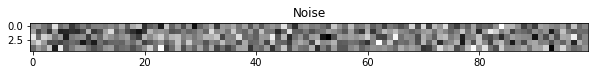

In [177]:
noise = np.random.normal(size=[5,latent_dim])
gen_image = generator_model_1.predict(noise)
plt.figure(figsize=(10,4))
plt.imshow(noise)
plt.title("Noise")

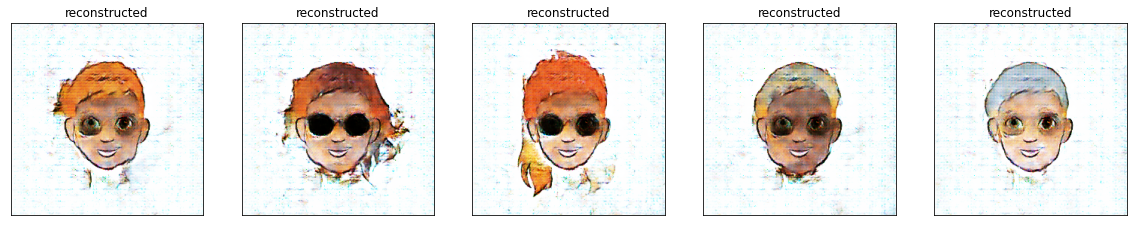

In [178]:
plt_reconstruction(5, gen_image)

Podemos ver que el gap entre el costo del discriminador y el generador es muy grande en comparación al tercer modelo del primer caso (fashion mnist). También podemos notar que estos costos tienen una gran variación en función de las épocas. Podemos observar que las imágenes creadas, a pesar de contar con bastante ruido en el contorno y en el caso de algunas, en los ojos, estas pueden ser consideradas como "satisfactorias", pues cada una de ellas, se asemeja a un personaje perteneciente al dataset. También es importante notar la variedad entre cada uno de ellos, es decir, todos los cambios que hay entre cada una de las imágenes, como lo es el color y la forma del cabello, el color de pies y los ojos.

## Tercer modelo - Cartoon dataset

In [179]:
latent_dim = 100
generator_model_2 = Sequential(
    [Dense(4*4*256,activation="relu",input_dim=latent_dim),
     BatchNormalization(),
     LeakyReLU(0.2),
     Reshape((4, 4, 256)),
     Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False),
     Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False),
     BatchNormalization(),
     LeakyReLU(0.2),
     Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False),
     BatchNormalization(),
     LeakyReLU(0.2),
     Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'),
     BatchNormalization(),
     LeakyReLU(0.2),
     Conv2DTranspose(64, (5, 5), strides=(3, 3), padding='same', use_bias=False, activation='tanh'),
     BatchNormalization(),
     LeakyReLU(0.2),
     Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh')],
    name="Generator"
)
generator_model_2.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 4096)              413696    
                                                                 
 batch_normalization_34 (Bat  (None, 4096)             16384     
 chNormalization)                                                
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 4096)              0         
                                                                 
 reshape_11 (Reshape)        (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_25 (Conv2D  (None, 8, 8, 256)        1638400   
 Transpose)                                                      
                                                                 
 conv2d_transpose_26 (Conv2D  (None, 16, 16, 256)      16

In [180]:
discriminator_5 = Sequential(
    [Conv2D(32, kernel_size=3, strides=2, input_shape=(256,256,3), padding="same"),
     LeakyReLU(alpha=0.2),
     Dropout(0.2),
     Conv2D(64, kernel_size=3, strides=2, padding="same"),
     ZeroPadding2D(padding=((0,1),(0,1))),
     BatchNormalization(momentum=0.7),
     LeakyReLU(alpha=0.3),
     Dropout(0.2),
     Conv2D(128, kernel_size=3, strides=2, padding="same"),
     BatchNormalization(momentum=0.8),
     LeakyReLU(alpha=0.2),
     Dropout(0.2),
     Conv2D(256, kernel_size=3, strides=1, padding="same"),
     BatchNormalization(momentum=0.7),
     LeakyReLU(alpha=0.3),
     Dropout(0.2),
     Conv2D(512, kernel_size=3, strides=1, padding="same"),
     BatchNormalization(momentum=0.8),
     LeakyReLU(alpha=0.2),
     Dropout(0.2),
     Flatten(),
     Dense(1, activation='sigmoid')]
)
discriminator_5.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 leaky_re_lu_25 (LeakyReLU)  (None, 128, 128, 32)      0         
                                                                 
 dropout_17 (Dropout)        (None, 128, 128, 32)      0         
                                                                 
 conv2d_23 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 zero_padding2d (ZeroPadding  (None, 65, 65, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_39 (Bat  (None, 65, 65, 64)       256       
 chNormalization)                                     

In [181]:
gan_5 = GAN(discriminator=discriminator_5,
            generator=generator_model_2, 
            latent_dim=latent_dim)
lr = 0.001
gan_5.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=lr, beta_1 = 0.5),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=lr, beta_1 = 0.5),
    loss_fn=tf.keras.losses.BinaryCrossentropy(),
)

In [182]:
gan_5.fit(normalized_data, epochs=50)

Epoch 1/50


ValueError: ignored

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


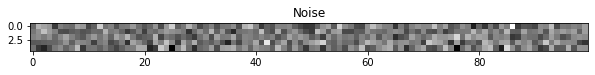

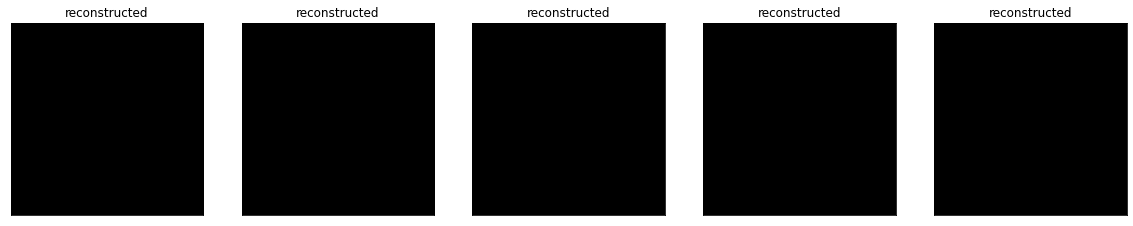

In [183]:
noise = np.random.normal(size=[5,latent_dim])
gen_image = generator_model_2.predict(noise)
plt.figure(figsize=(10,4))
plt.imshow(noise)
plt.title("Noise")

plt_reconstruction(5, gen_image)